# IEMS 469 - Reinforcement Learning HW4

## An implementation of the UCB algorithm on the contextual bandit problem

### Load Data

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import math
import tensorflow as tf

def sample_jester_data(file_name, context_dim = 32, num_actions = 8, num_contexts = 19181,
shuffle_rows=True, shuffle_cols=False):
   np.random.seed(0)
   with tf.io.gfile.GFile(file_name, 'rb') as f:
        dataset = np.load(f)
        
   if shuffle_cols:
      dataset = dataset[:, np.random.permutation(dataset.shape[1])]
   if shuffle_rows:
      np.random.shuffle(dataset)
      dataset = dataset[:num_contexts, :]
   assert context_dim + num_actions == dataset.shape[1], 'Wrong data dimensions.'
   opt_actions = np.argmax(dataset[:, context_dim:], axis=1)
   opt_rewards = np.array([dataset[i, context_dim + a] for i, a in enumerate(opt_actions)])
   return dataset, opt_rewards, opt_actions

dataset, opt_rewards, opt_actions = sample_jester_data('C:\\Users\\Home\\jester_data_40jokes_19181users.npy')

n_actions = 8
n_features = 32
alpha = 1.5
A = []
b = []
theta = []
for i in range(n_actions):
    A.append(np.eye(32))
    
for i in range(n_actions):
    b.append(np.zeros((32,1)))
    
for i in range(n_actions):
    theta.append(np.zeros((32,1)))

## Train-Validation sets split

In [16]:
train_set = dataset[0:18000, 0:32]
rewards = dataset[0:18000,32:40]
T = train_set.shape[0]
test_set = dataset[18000:, 0:32]
test_rewards = dataset[18000:, 32:40]
test_opt_rewards = opt_rewards[18000:]
n_samples = test_set.shape[0]

## Main UCB Loop

In [17]:
score = np.zeros(n_actions)
for idx in range(T):
    #Observe features 
    x = train_set[idx, :]
    for a in range(n_actions):
        score[a] = np.dot(x, theta[a])[0] + alpha * math.sqrt(x @ np.linalg.inv(A[a]) @ x.T)
        
    #action selection
    action = np.argmax(score)
    #observe payoff
    reward = rewards[idx, action]
    #update
    A[action] = A[action] + x.T @ x
    b[action] = b[action] + reward * x.T
    theta[action] = np.linalg.inv(A[action]) @ b[action]
    

## Evaluate the learned model on the testing set

In [18]:
regret = np.zeros(n_samples)
for idx in range(n_samples):
    x = test_set[idx, :]
    for a in range(n_actions):
        
        score[a] = np.dot(x, theta[a])[0]
        
    action = np.argmax(score)
    regret[idx] = (test_opt_rewards[idx] - test_rewards[idx, action])

## Plot of the regrets across testing samples

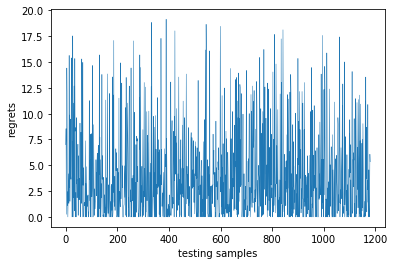

In [19]:
plt.plot(regret, linewidth=0.5)
plt.xlabel('testing samples')
plt.ylabel('regrets')
plt.show()